<a href="https://colab.research.google.com/github/MarekSroka/Bank_Deposits/blob/main/working_copy_orig__Bank_deposit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TREŚĆ ZADANIA**

W pliku Bank Marketing data.csv znajdują się dane charakteryzujące klientów pewnego banku oraz kampanie marketingowe skierowane do tych klientów. Dołączone są ponadto wskaźniki społeczne i ekonomiczne. Na podstawie tych danych należy zbudować model prognozujący szansę, że klient w wyniku prowadzonej kampanii założy lokatę terminową. Szczegółowy opis danych znajduje się w pliku Description.txt (opis jest w języku angielskim). Proszę się z nim zapoznać, gdyż zawiera ważne z punktu widzenia modelowania informacje.
Proszę o przesłanie raportu w którym opisana zostanie budowa modelu. Proszę zawrzeć w raporcie opis poszczególnych kroków prowadzących do powstania modelu.
Format pliku: pdf, word
Język raportu: polski lub angielski (nie ma to znaczenia dla oceny)

Title: Bank Marketing data (with social/economic context)

3. Time range: from May 3008 to November 2010

3. Attribute information:

   Input variables:
   # Bank client data:

   1 - age (numeric)

   2 - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")

   3 - marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)

   4 - education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")

   5 - default: has credit in default? (categorical: "no","yes","unknown")

   6 - housing: has housing loan? (categorical: "no","yes","unknown")

   7 - loan: has personal loan? (categorical: "no","yes","unknown")

   # Related with the last contact of the current campaign:

   8 - contact: contact communication type (categorical: "cellular","telephone")

   9 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")

  10 - day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")

  11 - duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

   # Other attributes:
  12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

  13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

  14 - previous: number of contacts performed before this campaign and for this client (numeric)

  15 - poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")

   # Social and economic context attributes

  16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)

  17 - cons.price.idx: consumer price index - monthly indicator (numeric)
     
  18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
     
  19 - euribor3m: euribor 3 month rate - daily indicator (numeric)

  20 - nr.employed: number of employees - quarterly indicator (numeric)

  Output variable (desired target):
  21 - y - has the client subscribed a term deposit? (binary: "yes","no")


4. Missing Attribute Values: There are several missing values in some categorical attributes, all coded with the "unknown" label.


5. The goal is to assess the probability that the client will subscribe a bank term deposit (variable y).

# Import and install libraries \ notebook settings

In [259]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [260]:
# pip install --upgrade pip
!pip install sweetviz
!pip install dtale
!pip install plotly
!pip install ppscore
!pip install eli5

In [284]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sts


from google.colab import data_table
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.model_selection import ParameterGrid

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn import svm
from imblearn.over_sampling import RandomOverSampler

from sklearn.base import is_classifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn. metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
import xgboost as xgb
from scipy import stats

import eli5
from eli5.sklearn import PermutationImportance

#installed libraries
import sweetviz as sw
import dtale
import dtale.app as dtale_app
import plotly.graph_objs as go
# import plotly.graph_objects as go
import ppscore as pps


In [285]:
pd.set_option('display.max_columns', None)
data_table.enable_dataframe_formatter()

# Functions

In [286]:
# funkcja sprawedzjąca feature importance - dla modeli, dla których jest dostęp do klasyfikatora

def calculate_and_print_feature_importance(model, feature_names):
    if isinstance(model, Pipeline_imb):
        # Find the classifier step in the pipeline
        classifier_step = None
        for step_name, step in model.named_steps.items():
            if is_classifier(step):
                classifier_step = step
                break

        if classifier_step is not None:
            # Extract the coefficients from the classifier
            coefficients = classifier_step.coef_[0] if hasattr(classifier_step, 'coef_') else None

            if coefficients is not None:
                # Calculate the absolute values of the coefficients as feature importances
                feature_importances = np.abs(coefficients)

                # Combine feature names with their importances
                feature_importance_dict = dict(zip(feature_names, feature_importances))

                # Sort features by importance in descending order
                sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

                # Print or analyze the feature importances
                for feature, importance in sorted_feature_importance:
                    print(f"Feature: {feature}, Importance: {importance}")
            else:
                print("Coefficient information not available for the classifier.")
        else:
            print("Classifier not found in the pipeline.")
    elif hasattr(model, 'coef_'):
        # Extract the coefficients from the LogisticRegression model
        coefficients = model.coef_[0]

        # Calculate the absolute values of the coefficients as feature importances
        feature_importances = np.abs(coefficients)

        # Combine feature names with their importances
        feature_importance_dict = dict(zip(feature_names, feature_importances))

        # Sort features by importance in descending order
        sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

        # Print or analyze the feature importances
        for feature, importance in sorted_feature_importance:
            print(f"Feature: {feature}, Importance: {importance}")
    else:
        print("Coefficient information not available for the model.")

In [287]:
# funkcja sprawedzjąca feature importance - dla modeli, dla nie ma dostępu do klasyfikatora

def calculate_and_print_feature_importance_2(model, X, y):
    # Utwórz obiekt PermutationImportance
    perm = PermutationImportance(model, random_state=seed)
    # Dopasuj model do danych
    perm.fit(X, y)

    # Wyświetl znaczenie cech
    feature_importance = eli5.explain_weights(perm, feature_names=X.columns.tolist(), top=None, target_names=["Outcome"])
    print(eli5.format_as_text(feature_importance))

In [288]:
# support functions for Using Label Encoder in the Pipeline

class LabelEncoderTransformer:
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for column in X_copy.columns:
            le = LabelEncoder()
            X_copy[column] = le.fit_transform(X_copy[column])
        return X_copy

In [289]:
# bez plotowania AUC roc na 1 wykresie

metrics_dataframe = pd.DataFrame(columns=['Model', 'F1_score', 'AUC'])

models = []

def calculation_metrics(model, model_name):
    global metrics_dataframe

    predictions = model.predict(X_test_data)
    predictions_proba = model.predict_proba(X_test_data)

    # Precision, Recall, F1
    print(classification_report(y_test_data, predictions))

    # ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    fpr, tpr, thresholds = roc_curve(y_test_data, predictions_proba[:, 1])
    plt.plot(fpr, tpr, label=model_name)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    print('======' * 20)

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_test_data, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    plt.xlabel('Predicted values')
    plt.ylabel('Actual values')
    plt.title(f'\nConfusion matrix for {model_name}\n')
    plt.show()

    # AUC and F1 score

    f1score = f1_score(y_test_data, predictions)
    auc = roc_auc_score(y_test_data, predictions_proba[:, 1])

    metrics_dataframe = metrics_dataframe.append({'Model': model_name, 'F1_score': f1score, 'AUC': auc},
                                                 ignore_index=True)

    return metrics_dataframe



# Now, metrics_dataframe contains the metrics for all the models.


# Loading data

In [290]:
df = pd.read_csv('/content/gdrive/MyDrive/000.Projekt_KRD/Bank Marketing data.csv', delimiter=';', na_values=['unknown'])

# EDA


### Sweetviz library for EDA

In [291]:
# analyse_report = sw.analyze(df)

In [292]:
# analyse_report.show_html('df_start.html', open_browser=True)

In [293]:
# current_datetime = str(datetime.now().strftime("%Y_%m_%d_%H%M"))
# raport = analyse_report.show_html('total_df_' + current_datetime +'.html', open_browser=True)

### dtale library for EDA

In [294]:
# dtale_app.USE_COLAB = True

# dtale.show(df_oversampled)

In [295]:
# dtale.instances()

In [296]:
# dtale.get_instance(1).kill()

## Basic information and statistics

In [297]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4080 non-null   object 
 2   marital         4108 non-null   object 
 3   education       3952 non-null   object 
 4   default         3316 non-null   object 
 5   housing         4014 non-null   object 
 6   loan            4014 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

In [298]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000
mean,40.113620,256.788055,2.537266,960.422190,0.190337,0.084972,93.579704,-40.499102,3.621356,5166.481695
std,10.313362,254.703736,2.568159,191.922786,0.541788,1.563114,0.579349,4.594578,1.733591,73.667904
min,18.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.635000,4963.600000
25%,32.000000,103.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000
50%,38.000000,181.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,317.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,88.000000,3643.000000,35.000000,999.000000,6.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [299]:
#ilość wierszy z wartością null w DF
df.isnull().sum()

age                 0
job                39
marital            11
education         167
default           803
housing           105
loan              105
contact             0
month               0
day_of_week         0
duration            0
campaign            0
pdays               0
previous            0
poutcome            0
emp.var.rate        0
cons.price.idx      0
cons.conf.idx       0
euribor3m           0
nr.employed         0
y                   0
dtype: int64

##Columns Review

Age column

In [300]:
if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
    df = df.to_frame(index=False)

# remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]  # update columns to strings in case they are numbers

s = df[~pd.isnull(df['age'])][['age']]
chart, labels = np.histogram(s['age'], bins=15)

# main statistics
stats = df['age'].describe().to_frame().T
charts = [
    go.Bar(x=labels[1:], y=chart, name='Histogram')
]

figure = go.Figure(data=charts, layout=go.Layout({
    'barmode': 'group',
    'legend': {'orientation': 'h'},
    'title': {'text': 'age Histogram (bins: 15)'},
    'yaxis': {'side': 'left', 'title': {'text': 'Frequency'}}
}))

figure.show()

In [301]:
#transform month and day of week into categorical data

month_order = ['jan', 'feb', 'mar', "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]

df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)

day_order = ["mon","tue","wed","thu","fri"]

df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=day_order, ordered=True)

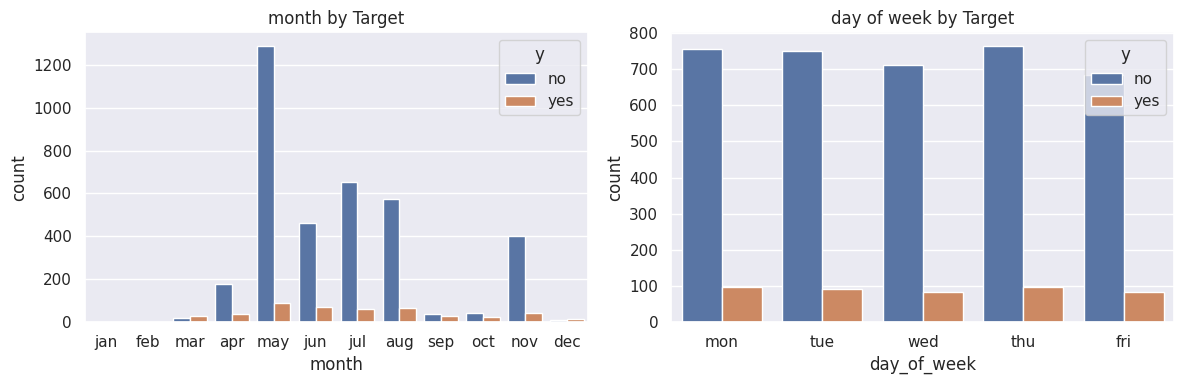

In [302]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

sns.countplot(x='month', hue='y', data=df)
plt.title('month by Target')

plt.subplot(1, 2, 2)
sns.countplot(x='day_of_week', hue='y', data=df)
plt.title('day of week by Target')

plt.tight_layout()
plt.show()

In [303]:
# groupby month, day of week with target variable

df_agg = df.groupby(['month', 'day_of_week', 'y']).size().reset_index(name='count')

In [304]:
df_agg.head()

,month,day_of_week,y,count
0,jan,mon,no,0
1,jan,mon,yes,0
2,jan,tue,no,0
3,jan,tue,yes,0
4,jan,wed,no,0


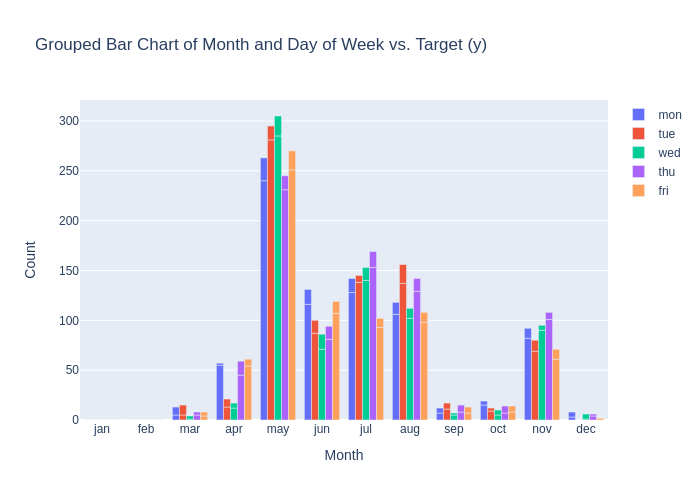

In [313]:
fig = go.Figure()

for day in df_agg['day_of_week'].unique():
    data = df_agg[df_agg['day_of_week'] == day]
    fig.add_trace(go.Bar(x=data['month'], y=data['count'], name=day))

fig.update_layout(
    barmode='group',
    xaxis=dict(title='Month'),
    yaxis=dict(title='Count'),
    title='Grouped Bar Chart of Month and Day of Week vs. Target (y)'
)

fig.show()
print()
fig.show('png') # werjsa do zapisania w GitHub

In [307]:
!pip install -q kaleido

In [309]:
fig = go.Figure()

for day in df_agg['day_of_week'].unique():
    data = df_agg[df_agg['day_of_week'] == day]
    fig.add_trace(go.Bar(x=data['month'], y=data['count'], name=day))

fig.update_layout(
    barmode='group',
    xaxis=dict(title='Month'),
    yaxis=dict(title='Count'),
    title='Grouped Bar Chart of Month and Day of Week vs. Target (y)'
)

# Zapisz wykres do pliku PNG
fig.write_image("chart.png")

In [306]:
stop

NameError: ignored

Duration column -

In [ ]:
print(df.groupby('y')['duration'].describe())

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='y', y='duration', data=df)
plt.title('Duration by Target')
plt.xlabel('Target')
plt.ylabel('Duration (seconds)')
plt.show()

In [ ]:
from scipy import stats

duration_yes = df[df['y'] == 'yes']['duration']
duration_no = df[df['y'] == 'no']['duration']
t_stat, p_value = stats.ttest_ind(duration_yes, duration_no)

print(f'T-test statistic: {t_stat}')
print(f'P-value: {p_value}')

# Check the significance level (usually 0.05)
alpha = 0.05
print("There is a significant difference between 'yes' and ' no' groups.") if p_value < alpha else print("There is no significant difference between 'yes' and 'no' groups.")

In [ ]:
num_bins = 15 # You can adjust the number of bins as needed
df['duration_category'] = pd.qcut(df['duration'], q=num_bins, labels=False)

# contingency_table = pd.crosstab(df['y'], df['duration_category'])
# chi2, p, _, _= chi2_contingency(contingency_table)

# print(f'Chi-squared statistic: {chi2}')
# print(f'P-value: {p}')

# alpha = 0.05
# print("There is a significant relationship between 'y' and 'duration_category'.") if p < alpha else print("There is no significant relationship between 'y' and 'duration_category'.")

In [ ]:
# cancel the duration column after benchmarking !!!

In [ ]:
df['duration_category']

Campaign column

In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='y', y='campaign', data=df)
plt.title(f'campaign by Target')
plt.xlabel('Target (y)')
plt.ylabel('Number of contacts')
plt.show()

In [ ]:
num_feat_01 = ['pdays', 'previous']

for f in num_feat_01:
  plt.figure(figsize=(6, 4))
  sns.boxplot(x=df['y'], y=df[f])
  plt.show()

In [ ]:
df.month.value_counts()

In [ ]:
df['y_numeric'] = df['y'].map({'yes': 1, 'no': 0}).astype('int')
df['month_numeric'] = df['month'].map({'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov':11, 'dec': 12 }).astype('int')

In [ ]:
df['month_numeric']

## Pairplot - financial coeff

In [ ]:
# sns.set(rc={"figure.figsize":(32, 12)})

# data_coeffs = ['month_numeric', 'emp.var.rate', 'cons.price.idx',  'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']

# sns.pairplot(df[data_coeffs], hue="y")

# plt.show()

## Relacje pomiędzy zmiennymi w Data Frame

### Wartości numeryczne między sobą

In [ ]:
numerical_features=[col for col in df.select_dtypes(include=['integer', 'float']).columns if col != 'y_numeric']
print(numerical_features)
print(len(numerical_features))
print(type(numerical_features))

In [ ]:
correlations=df[numerical_features].corr()
plt.figure(figsize=(10,8))

sns.heatmap(data=correlations,square=True,annot = True, cmap="YlGnBu")

plt.yticks(rotation=0)
plt.xticks(rotation=90)

In [ ]:
# Calculate and display PPS scores for all pairs of numeric variables
for var1 in numerical_features:
    for var2 in numerical_features:
        if var1 != var2:
            pps_score = pps.score(df, var1, var2)['ppscore']
            print(f'PPS Score between {var1} and {var2}: {pps_score:.2f}')

### Wartości numeryczne vs target column

In [ ]:
df_copy = df.copy()

In [ ]:
df_copy.head()

In [ ]:
y_numeric = df_copy.pop('y_numeric')

In [ ]:
X = df_copy
X.head()

In [ ]:
X[numerical_features].info()

In [ ]:
y_numeric.info()

In [ ]:
X

In [ ]:
# sprawdzenie korelacji między zmiennymi numerycznymi a targetem ('y_numeric')
for f in numerical_features:
  print(f'\nFeature: {f}')
  print(stats.pointbiserialr(X[f], y_numeric))

Wszsytkie zmienne mają wpływ (o róznym stopniu)  na z,ienna objaśnianą i jest onstatystycznie istotny.

## Wizualizacja danych kategorycznych

In [ ]:
categorical_features = [col for col in df.select_dtypes(include=['object', 'category']).columns if col != 'y']
print(categorical_features)
print(len(categorical_features))
print(type(categorical_features))

In [ ]:



plt.figure(figsize=(8, 30), facecolor='white')

rows = len(categorical_features)
cols = 1

for i, categorical_feature in enumerate(categorical_features, start=1):
    ax = plt.subplot(rows, cols, i)
    sns.countplot(y=categorical_feature, data=df)
    # plt.xlabel(categorical_feature)
    # plt.title(categorical_feature)

plt.tight_layout()

plt.show()

### Sprawdzenie relacji między zmiennymi kategorycznymi oraz targetem za pomconą Information gain w decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

target_col = 'y'
target = df[target_col]

df_cat_feat = df[categorical_features]

df_encoded = pd.get_dummies(df_cat_feat, columns=categorical_features, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(df_encoded, target, test_size=0.3, random_state=42)

clf = DecisionTreeClassifier(criterion='entropy')  # Information Gain criterion
clf.fit(X_train, y_train)

# Get feature importances (information gain)
feature_importance = clf.feature_importances_

# Create a dictionary mapping features to their importance
feature_importance_dict = dict(zip(df_encoded.columns, feature_importance))

# Sort the feature-importance dictionary by information gain
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True))

# Print the sorted feature-importance pairs
for feature, info_gain in sorted_feature_importance.items():
    print(f"Feature: {feature}, Information Gain: {info_gain:.4f}")

In summary, the results suggest that 'poutcome_success',  certain day-of-the-week, housing-related, loan features are the most influential in predicting the target variable 'y'.It is possible to use this information to prioritize feature selection or further investigate the relationships between these features and the target variable in your dataset.

In [ ]:
cat_features_vis = ['default', 'poutcome', 'housing', 'loan', 'day_of_week']

for f in cat_features_vis:
  plt.figure(figsize=(6, 4), facecolor='white')
  sns.countplot(x=f, hue='y', data=df)
  print()
  plt.title(f'{f} by target')

## analiza współczynników społecznych / ekonomicznych emp.var.rate', 'cons.price.idx',  'cons.conf.idx', 'euribor3m', 'nr.employed' - dodanie zmiennej year

zmiana wartości euribor na koszyki

In [ ]:
# Calculate the minimum and maximum values from the DataFrame
min_value_eur = df['euribor3m'].min()
max_value_eur = df['euribor3m'].max()

# Define the bin width
bin_width = 0.5

# # Create a list of bin edges (start, stop, and step)
# bins = [x for x in range(int(min_value_eur), int(max_value_eur) + 1, int(bin_width))]

# # Create a new column with the bin labels
# df['euribor3m_binned'] = pd.cut(df['euribor3m'], bins=bins, labels=bins[:-1])

# Create a list of bin edges (start, stop, and step) using numpy.arange
bins = np.arange(int(min_value_eur), int(max_value_eur) + bin_width, bin_width)

bins = np.linspace(int(min_value_eur), max_value_eur, num_bins + 1)

# Create a new column with the bin labels
df['euribor3m_binned'] = pd.cut(df['euribor3m'], bins=bins, labels=bins[:-1])

In [ ]:
print(df['euribor3m_binned'])
print(df['euribor3m'])

In [ ]:
len(df['euribor3m_binned'].unique())

In [ ]:
numerical_features.append('euribor3m_binned')

In [ ]:
for column in df[numerical_features]:
    unique_values = df[column].unique()
    print(f"Unique values in column {column}: {', '.join(map(str, unique_values))}")

In [ ]:
columns_coeff = ['emp.var.rate', 'cons.price.idx',  'cons.conf.idx', 'euribor3m', 'nr.employed', 'euribor3m_binned']

value_mappings = {}

for column in df[columns_coeff]:
    unique_values = df[column].unique()
    value_mapping = {value: i + 1 for i, value in enumerate(unique_values)}
    value_mappings[column] = value_mapping

for column in df[columns_coeff]:
    new_column_name = f"{column}_updated"
    df[new_column_name] = df[column].map(value_mappings[column])

print(df)

In [ ]:
# przyporządkowanie roku wierszom na bazie innych danych - 'euribor3m' oraz kolumny 'month' i reszty istniejących kolumn

In [ ]:
df['year'] = pd.np.where(df['euribor3m'] > 2.892, '2008', pd.np.where(df['euribor3m'] > 1.05, '2009' , 'others'))

In [ ]:
conditions = [
    (df['euribor3m'] > 2.892),
    (df['euribor3m'] > 1.05),
    (df['month_numeric'] == 12),
    ((df['month_numeric'] >= 3) & (df['month_numeric'] <= 6)),
    ((df['month_numeric'] == 7) & (df['nr.employed_updated'] == 7)), # wybieramy lipiec 2009 z wszystkich danych lipcowych
    ((df['month_numeric'] == 8) & (df['nr.employed_updated'] == 7)),
    ((df['month_numeric'] == 9) & (df['nr.employed_updated'] == 9)),
    ((df['month_numeric'] == 10) & (df['nr.employed_updated'] == 9)),
    ((df['month_numeric'] == 11) & (df['nr.employed_updated'] == 9))
]
choices = ['2008', '2009', '2009', '2010', '2009', '2009','2009', '2009', '2009']

df['year'] = pd.np.select(conditions, choices, default='2010')

In [ ]:
# dtale.show(df)

### visualization column results for variable 'y' (0/1 binary column) with distribution in month (feature) and year (feature) on 1 chart.

In [ ]:
df.groupby(['year', 'month_numeric'])['y_numeric'].count().unstack()

In [ ]:
result = df.groupby(['year', 'month_numeric'])['y'].count().unstack(fill_value=0)

# Plot the results as a bar chart
result.plot(kind='bar', figsize=(12, 6))
plt.title('Distribution of y by Month and Year')
plt.xlabel('Year-Month')
plt.ylabel('Count of y')
plt.legend(title='month_numeric')
plt.xticks(rotation=0)
plt.show()


In [ ]:
result = df.groupby(['year', 'y'])['y'].count().unstack(fill_value=0)
result

In [ ]:
result = df.groupby(['year', 'y'])['y'].count().unstack(fill_value=0)

# Create a list of labels with year below each group of months
x_labels = [f"{year}" for (year) in result.index]

# Plot the results as a bar chart
fig, ax = plt.subplots(figsize=(8, 5))  # Extend the width of the chart
result.plot(kind='bar', ax=ax)

# Set x-axis labels (grouping months by year)
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels)

plt.title('Distribution of y by Year')
plt.xlabel('Year')
plt.ylabel('Count of y')
plt.legend(title='y')
plt.xticks(rotation=45)
plt.show()

In [ ]:
result = df.groupby(['year', 'month_numeric', 'y'])['y'].count().unstack(fill_value=0)

# Create a list of labels with year below each group of months
x_labels = [f"{month}-{year}" for (year, month) in result.index]

# Plot the results as a bar chart
fig, ax = plt.subplots(figsize=(16, 6))  # Extend the width of the chart
result.plot(kind='bar', ax=ax)

# Set x-axis labels (grouping months by year)
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels)

plt.title('Distribution of y by Month and Year')
plt.xlabel('Year-Month')
plt.ylabel('Count of y')
plt.legend(title='y')
plt.xticks(rotation=45)
plt.show()

Widzimy, że zmienna y jest zupełnie odmniennie rozłożona w poszczególnych latach przy różnej ilości próbek w każdym z lat.

In [ ]:
df['month_object'] = df['month'].astype(str)

In [ ]:
df.head()

In [ ]:
# łączenie kolumn month and w jedną kolumnę
df['month_year'] = df['month_object'] + '_' + df['year'].astype('str')
df['month_year'] = df['month_year'].astype('category')

In [ ]:
df.head()

# Data Preprocessing

## Wartości null

In [ ]:
# Łącznie mamy 1029 wierszy z wartościami null (niektóre w kilku kolumnach)
# Dla 5 kolumn kategorycznych  wartości nulls są zdecydowaną mniejszością (od 1% od 4% wierszy) - dla nich uzupełnię nulle wartością najczęście spotykaną
# dla Kolumny 'default' aż 803 rekordy (19%) stanowią wartości null - z uwagi na to, przekształcę nulls jako odrębną wartość ('unknown'), kolumna ze względu na strukturę

In [ ]:
df['job'].fillna(df['job'].mode()[0], inplace=True)
df['marital'].fillna(df['marital'].mode()[0], inplace=True)
df['education'].fillna(df['education'].mode()[0], inplace=True)
df['housing'].fillna(df['housing'].mode()[0], inplace=True)
df['loan'].fillna(df['loan'].mode()[0], inplace=True)

In [ ]:
df.isnull().sum()

Strukura kolumny 'default', nie pozwala jej wziąć do modelowania

In [ ]:
df['default'].value_counts()

In [ ]:
df.info()

## Podział danych na zbiór treningowy i testowy

In [ ]:
df.head()

In [ ]:
# # kopia zestawu danych
# data = df.copy()
# data.head()

* bez kolumny 'default',
* w liście zapisane zmienne zmienne do modelowania

## Zestaw danych nr 1

Wszystkie zmienne początkowe


In [ ]:
model_columns = ['age', 'job', 'marital', 'education', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays',
       'previous', 'poutcome',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
      'y_numeric']

print(len(model_columns))
print(model_columns)

In [ ]:
data = df[model_columns]
y = data.pop('y_numeric')
y

In [ ]:
X = data
X.head()

In [ ]:
X.info()

Przy liście zmiennych pomijamy zmienną 'duration' - specyfika tej zmiennej jest taka, nie będziemy wiedzieli przed wykonaniem konaktu, jak długo potrwa (nie będzie dostępna w danych produkcyjnych)

In [ ]:
num_feat = [col for col in df[model_columns].select_dtypes(include=['integer', 'float']).columns if col != 'y_numeric']

cat_feat = [col for col in df[model_columns].select_dtypes(include=['object']).columns if col != 'y']

ord_feat = [col for col in df[model_columns].select_dtypes(include=['category']).columns if col != 'y']

print(f'No. of numerical features: {len(num_feat)}')
print(num_feat)
print()
print(f'No. of categorical features: {len(cat_feat)}')
print(cat_feat)
print()
print(f'No. of ordinal features: {len(ord_feat)}')
print(ord_feat)

In [ ]:
seed = 23

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [ ]:
y_train.value_counts()

In [ ]:
361 / (2934+361)

In [ ]:
y_test.value_counts()

### Feature Importance - RandomForestClassifier() - Zestaw danych nr 1

In [ ]:
categorical_transformer = Pipeline(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, cat_feat),
        ('ordinal', ordinal_transformer, ord_feat)
    ]
)

rfc_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('rfc_model', RandomForestClassifier(random_state=seed))])

In [ ]:
rfc_pipeline.fit(X_train, y_train)

In [ ]:
feature_importance = rfc_pipeline.steps[-1][1].feature_importances_
all_column_names = X_train.columns

importance_tuples = [(col, imp) for col, imp in zip(all_column_names, feature_importance)]

# Sort the list by feature importance in descending order
rfc_pre_sorted_importance = sorted(importance_tuples, key=lambda x: x[1], reverse=True)

# Print feature importance values for each column in descending order
print('Random Forest Feature Importance: \n')
for column, importance in rfc_pre_sorted_importance:
    print(f" {column}: {importance}")

## Zestaw danych nr 2

z nowo stworzoną zmienną month_year oraz wybranym 1 z 5 wskaźników finansowych  wuagi na ich wysoką kolerację i wspólne zależności (ppsscore) )

In [ ]:
model_columns_2 = ['age', 'job', 'marital', 'education', 'housing', 'loan',
       'contact', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome',
        'emp.var.rate', 'month_year',
        'y_numeric']

print(len(model_columns_2))
print(model_columns_2)

In [ ]:
data_2 = df[model_columns_2]

In [ ]:
y_2 = data_2.pop('y_numeric')
y_2

In [ ]:
X_2 = data_2
X_2.head()

In [ ]:
num_feat_2 = [col for col in df[model_columns_2].select_dtypes(include=['integer', 'float']).columns if col != 'y_numeric']
cat_feat_2 = [col for col in df[model_columns_2].select_dtypes(include=['object']).columns if col != 'y']
ord_feat_2 = [col for col in df[model_columns_2].select_dtypes(include=['category']).columns if col != 'y']
print(f'No. of numerical features: {len(num_feat_2)}')
print(num_feat_2)
print()
print(f'No. of categorical features: {len(cat_feat_2)}')
print(cat_feat_2)
print()
print(f'No. of ordinal features: {len(ord_feat_2)}')
print(ord_feat_2)

In [ ]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=seed, stratify=y)

In [ ]:
X_train_2.shape, y_train_2.shape, X_test_2.shape, y_test_2.shape

In [ ]:
y_train_2.value_counts()

In [ ]:
361 / (2934+361)

In [ ]:
y_test_2.value_counts()

In [ ]:
90 / (734+90)

### Feature Importance - RandomForestClassifier() - Zestaw danych nr 2

In [ ]:
categorical_transformer = Pipeline(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, cat_feat_2),
        ('ordinal', ordinal_transformer, ord_feat_2)
    ]
)

rfc_pipeline_2 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('rfc_model_2', RandomForestClassifier(random_state=seed))])

In [ ]:
rfc_pipeline_2.fit(X_train_2, y_train_2)

In [ ]:
feature_importance = rfc_pipeline_2.steps[-1][1].feature_importances_
all_column_names = X_train_2.columns

importance_tuples = [(col, imp) for col, imp in zip(all_column_names, feature_importance)]

# Sort the list by feature importance in descending order
rfc_pre_sorted_importance = sorted(importance_tuples, key=lambda x: x[1], reverse=True)

# Print feature importance values for each column in descending order
print('Random Forest Feature Importance - zestaw danych 2: \n')
for column, importance in rfc_pre_sorted_importance:
    print(f" {column}: {importance}")

In [ ]:
# stop

## Zestaw danych 3

-  pozostawiono 2 zmienne społeczono - ekonomiczne wybrane ze względu na ich istotnoś

In [ ]:
df.head()

In [ ]:
model_columns_3 = ['age', 'job', 'marital', 'education', 'housing', 'loan',
       'contact', 'day_of_week', 'campaign', 'pdays','previous', 'poutcome',
        'month','cons.price.idx', 'emp.var.rate',
        'y_numeric']

print(len(model_columns_3))
print(model_columns_3)

In [ ]:
data_3 = df[model_columns_3]

y_3 = data_3.pop('y_numeric')
y_3

In [ ]:
X_3 = data_3
X_3.head()

In [ ]:
num_feat_3 = [col for col in df[model_columns_3].select_dtypes(include=['integer', 'float']).columns if col != 'y_numeric']
cat_feat_3 = [col for col in df[model_columns_3].select_dtypes(include=['object']).columns if col != 'y']
ord_feat_3 = [col for col in df[model_columns_3].select_dtypes(include=['category']).columns if col != 'y']
print(f'No. of numerical features: {len(num_feat_3)}')
print(num_feat_3)
print()
print(f'No. of categorical features: {len(cat_feat_3)}')
print(cat_feat_3)
print()
print(f'No. of ordinal features: {len(ord_feat_3)}')
print(ord_feat_3)

In [ ]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.2, random_state=seed, stratify=y)

X_train_3.shape, y_train_3.shape, X_test_3.shape, y_test_3.shape

In [ ]:
print(y_train_3.value_counts())

In [ ]:
print(y_test_3.value_counts())

### Feature Importance - RandomForestClassifier() - Zestaw danych nr 3

In [ ]:
categorical_transformer = Pipeline(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, cat_feat_3),
        ('ordinal', ordinal_transformer, ord_feat_3)
    ]
)

rfc_pipeline_3 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('rfc_model_3', RandomForestClassifier(random_state=seed))])

In [ ]:
rfc_pipeline_3.fit(X_train_3, y_train_3)

In [ ]:
feature_importance = rfc_pipeline_3.steps[-1][1].feature_importances_
all_column_names = X_train_3.columns

importance_tuples = [(col, imp) for col, imp in zip(all_column_names, feature_importance)]

# Sort the list by feature importance in descending order
rfc_pre_sorted_importance = sorted(importance_tuples, key=lambda x: x[1], reverse=True)

# Print feature importance values for each column in descending order
print('Random Forest Feature Importance - zestaw danych 3: \n')
for column, importance in rfc_pre_sorted_importance:
    print(f" {column}: {importance}")

## Zestaw danych 4

- mix 2 i 3 zestawu - month_year zostawiony +  pozostawiono 2 zmienne społeczono - ekonomiczne wybrane ze względu na ich istotność

In [ ]:
model_columns_4 = ['age', 'job', 'marital', 'education', 'housing', 'loan',
       'contact', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome',
       'cons.price.idx', 'emp.var.rate', 'month_year',
        'y_numeric']

print(len(model_columns_4))
print(model_columns_4)

In [ ]:
data_4 = df[model_columns_4]


In [ ]:
y_4 = data_4.pop('y_numeric')

In [ ]:
X_4 = data_4

In [ ]:
num_feat_4 = [col for col in df[model_columns_4].select_dtypes(include=['integer', 'float']).columns if col != 'y_numeric']
cat_feat_4 = [col for col in df[model_columns_4].select_dtypes(include=['object']).columns if col != 'y']
ord_feat_4 = [col for col in df[model_columns_4].select_dtypes(include=['category']).columns if col != 'y']

print(f'No. of numerical features: {len(num_feat_4)}')
print(num_feat_4)
print()
print(f'No. of categorical features: {len(cat_feat_4)}')
print(cat_feat_4)
print()
print(f'No. of ordinal features: {len(ord_feat_4)}')
print(ord_feat_4)

In [ ]:
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4, y_4, test_size=0.2, random_state=seed, stratify=y)

In [ ]:
print()

print(X_train_4.shape, y_train_4.shape, X_test_4.shape, y_test_4.shape)

y_train_4.value_counts()

y_test_4.value_counts()

### Feature Importance - RandomForestClassifier() - Zestaw danych nr 4

In [ ]:
categorical_transformer = Pipeline(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, cat_feat_4),
        ('ordinal', ordinal_transformer, ord_feat_4)
    ]
)

rfc_pipeline_4 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('rfc_model_4', RandomForestClassifier(random_state=seed))])

In [ ]:
rfc_pipeline_4.fit(X_train_4, y_train_4)

In [ ]:
feature_importance = rfc_pipeline_4.steps[-1][1].feature_importances_
all_column_names = X_train_4.columns

importance_tuples = [(col, imp) for col, imp in zip(all_column_names, feature_importance)]

# Sort the list by feature importance in descending order
rfc_pre_sorted_importance = sorted(importance_tuples, key=lambda x: x[1], reverse=True)

# Print feature importance values for each column in descending order
print('Random Forest Feature Importance - zestaw danych 4: \n')
for column, importance in rfc_pre_sorted_importance:
    print(f" {column}: {importance}")

In [ ]:
# stop

## Zestaw danych 5 - oversampling

*   na bazie podziału na nowo utworzonej kolumnie 'year', zrobimy oversampling dla danych z 2009 i 2010r. (2008 bez zmian) dal wszsytkich danych zaliczonych do datatype (poza 'year')




In [ ]:
model_columns_sampling = ['age', 'job', 'marital', 'education', 'housing', 'loan',
       'contact', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome',
       'cons.conf.idx', 'emp.var.rate', 'month', 'year',
      'y_numeric']

print(len(model_columns_sampling))
print(model_columns_sampling)

In [ ]:
df_sampling = df[model_columns_sampling]
df_sampling.shape

In [ ]:
df_sampling['year'] = df_sampling['year'].astype('int')

In [ ]:
df_sampling.info()

In [ ]:
cat_feat_sampling = [col for col in df_sampling.select_dtypes(include=['object', 'category']).columns]
cat_feat_sampling

In [ ]:
df_encoded = pd.get_dummies(df_sampling, columns=cat_feat_sampling)

df_encoded.shape

In [ ]:
df_encoded.info()

In [ ]:
df_2008 = df_encoded[df_sampling['year'] == 2008]
print(df_2008.shape)
df_2009_2010 = df_encoded[df_sampling['year'].isin([2009, 2010])]
print(df_2009_2010.shape)

In [ ]:


X_2009_2010 = df_2009_2010.drop(columns=['y_numeric'])
y_2009_2010 = df_2009_2010['y_numeric']

# Inicjalizacja RandomOverSampler
ros = RandomOverSampler(sampling_strategy={0: 1025*2, 1: 317*2}, random_state=seed) # podniesienie ilości obserwacji dwurkotnie z zachowaniem proprocji między etykietami

# Zastosowanie RandomOverSampler do X i y
X_resampled, y_resampled = ros.fit_resample(X_2009_2010, y_2009_2010)

df_resampled = pd.DataFrame(data=X_resampled, columns=X_2009_2010.columns)
df_resampled['y_numeric'] = y_resampled

df_oversampled = pd.concat([df_2008, df_resampled], ignore_index=True)

In [ ]:
df_2008.info()

In [ ]:
df_resampled.info()

In [ ]:
df_oversampled.info()

In [ ]:
df.groupby(['year', 'y_numeric'])['y_numeric'].count().unstack(fill_value=0)

In [ ]:
df_resampled.groupby(['year', 'y_numeric'])['y_numeric'].count().unstack(fill_value=0)

In [ ]:
df_oversampled.groupby(['year', 'y_numeric'])['y_numeric'].count().unstack(fill_value=0)

In [ ]:
grouped_data = df_oversampled.groupby(['year', 'y_numeric'])['y_numeric'].count().unstack(fill_value=0)

grouped_data.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Count of y')
plt.title('Count of y by Year')
plt.legend(title='y_numeric', labels=['no', 'yes'])
plt.show()

In [ ]:
df_oversampled.info()

In [ ]:
categories = []

for column in df_oversampled.columns:

    patterns = ["job_", "marital_", "housing_", "education_", "contact_", "loan_", "day_of_week_", "poutcome_", "month_"]

    for pattern in patterns:
        if pattern in column:
            categories.append(column)

In [ ]:
patterns = ["job_", "marital_", "housing_", 'education_', 'contact_', 'loan_', 'day_of_week_', 'poutcome_', 'month_']

In [ ]:
categories

In [ ]:
job_categories = []
marital_categories = []
housing_categories = []
education_categories = []
contact_categories = []
loan_categories = []
day_of_week_categories = []
poutcome_categories = []
month_categories = []

# Iteruj przez 'categories' i podziel na kategorie na podstawie wzorców
for category in categories:
    for pattern in patterns:
        if category.startswith(pattern):
            if pattern == "job_":
                job_categories.append(category)
            elif pattern == "marital_":
                marital_categories.append(category)
            elif pattern == "housing_":
                housing_categories.append(category)
            elif pattern == "education_":
                education_categories.append(category)
            elif pattern == "contact_":
                contact_categories.append(category)
            elif pattern == "loan_":
                loan_categories.append(category)
            elif pattern == "day_of_week_":
                day_of_week_categories.append(category)
            elif pattern == "poutcome_":
                poutcome_categories.append(category)
            elif pattern == "month_":
                month_categories.append(category)


In [ ]:
print(contact_categories)
print(loan_categories)

In [ ]:
print(month_categories)

In [ ]:
# job_category_df_oversampled

In [ ]:
# Odtwórz oryginalne kategorie na podstawie kolumn numerycznych
df_oversampled['job'] = df_oversampled[job_categories].idxmax(axis=1)
df_oversampled['marital'] = df_oversampled[marital_categories].idxmax(axis=1)
df_oversampled['housing'] = df_oversampled[housing_categories].idxmax(axis=1)
df_oversampled['education'] = df_oversampled[education_categories].idxmax(axis=1)
df_oversampled['contact'] = df_oversampled[contact_categories].idxmax(axis=1)
df_oversampled['loan'] = df_oversampled[loan_categories].idxmax(axis=1)
df_oversampled['day_of_week'] = df_oversampled[day_of_week_categories].idxmax(axis=1)
df_oversampled['poutcome'] = df_oversampled[poutcome_categories].idxmax(axis=1)
df_oversampled['month'] = df_oversampled[month_categories].idxmax(axis=1)
# Odtwórz pozostałe oryginalne kategorie


df_oversampled['marital'] = df_oversampled[marital_categories].idxmax(axis=1)
df_oversampled['housing'] = df_oversampled[housing_categories].idxmax(axis=1)
df_oversampled['education'] = df_oversampled[education_categories].idxmax(axis=1)
df_oversampled['contact'] = df_oversampled[contact_categories].idxmax(axis=1)
df_oversampled['loan'] = df_oversampled[loan_categories].idxmax(axis=1)
df_oversampled['day_of_week'] = df_oversampled[day_of_week_categories].idxmax(axis=1)
df_oversampled['poutcome'] = df_oversampled[poutcome_categories].idxmax(axis=1)
df_oversampled['month'] = df_oversampled[month_categories].idxmax(axis=1)

# # Usuń kolumny numeryczne
df_oversampled = df_oversampled.drop(columns=job_categories)
df_oversampled = df_oversampled.drop(columns=marital_categories)
df_oversampled = df_oversampled.drop(columns=housing_categories)
df_oversampled = df_oversampled.drop(columns=education_categories)
df_oversampled = df_oversampled.drop(columns=contact_categories)
df_oversampled = df_oversampled.drop(columns=loan_categories)
df_oversampled = df_oversampled.drop(columns=day_of_week_categories)
df_oversampled = df_oversampled.drop(columns=poutcome_categories)
df_oversampled = df_oversampled.drop(columns=month_categories)
# Usuń pozostałe kolumny numeryczne

# Teraz DataFrame df_oversampled ma oryginalne kategorie
df_oversampled.info()

In [ ]:
df_oversampled[cat_feat_sampling]

In [ ]:
df_oversampled['job'] = df_oversampled['job'].str.replace('job_', '')
df_oversampled['job']

In [ ]:
df_oversampled['marital'] = df_oversampled['marital'].str.replace('marital_', '')
df_oversampled['marital']

In [ ]:
df_oversampled['housing'] = df_oversampled['housing'].str.replace('housing_', '')
df_oversampled['housing']

In [ ]:
df_oversampled['education'] = df_oversampled['education'].str.replace('education_', '')
df_oversampled['education']

In [ ]:
df_oversampled['contact'] = df_oversampled['contact'].str.replace('contact_', '')
df_oversampled['contact']


In [ ]:
df_oversampled['loan'] = df_oversampled['loan'].str.replace('loan_', '')
df_oversampled['loan']

In [ ]:
df_oversampled['month'] = df_oversampled['month'].str.replace('month_', '')
df_oversampled['month']

In [ ]:
df_oversampled['day_of_week'] = df_oversampled['day_of_week'].str.replace('day_of_week_', '')
df_oversampled['day_of_week']

In [ ]:
df_oversampled['month_year'] = df_oversampled['month'] + '_' + df_oversampled['year'].astype('str')

In [ ]:
df_oversampled.info()

In [ ]:
df_oversampled.drop(columns='month', inplace=True)

In [ ]:
df_oversampled['month_year'] = df_oversampled['month_year'].astype('category')
df_oversampled['day_of_week'] = df_oversampled['day_of_week'].astype('category')

In [ ]:
df_oversampled.info()

### Przygotowanie do modelowania

In [ ]:
model_columns_5 = ['age', 'job', 'marital', 'education', 'housing', 'loan',
       'contact', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome',
       'cons.conf.idx', 'emp.var.rate', 'month_year',
      'y_numeric']

print(len(model_columns_5))
print(model_columns_5)

In [ ]:
data_5 = df_oversampled[model_columns_5]

In [ ]:
y_5 = data_5.pop('y_numeric')
X_5 = data_5

In [ ]:
y_5.shape

In [ ]:
X_5.shape

In [ ]:
num_feat_5 = [col for col in df_oversampled[model_columns_5].select_dtypes(include=['integer', 'float']).columns if col != 'y_numeric']
cat_feat_5 = [col for col in df_oversampled[model_columns_5].select_dtypes(include=['object']).columns if col != 'y']
ord_feat_5 = [col for col in df_oversampled[model_columns_5].select_dtypes(include=['category']).columns if col != 'y']

print(f'No. of numerical features: {len(num_feat_5)}')
print(num_feat_5)
print()
print(f'No. of categorical features: {len(cat_feat_5)}')
print(cat_feat_5)
print()
print(f'No. of ordinal features: {len(ord_feat_5)}')
print(ord_feat_5)

In [ ]:
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_5, y_5, test_size=0.2, random_state=seed, stratify=y_5)

In [ ]:
print(X_train_5.shape, y_train_5.shape, X_test_5.shape, y_test_5.shape)

In [ ]:
y_train_5.value_counts()

In [ ]:
614 / (3754+614)

In [ ]:
y_test_5.value_counts()

In [ ]:
154 / (939 + 154)

### Feature Importance - RandomForestClassifier() - Zestaw danych nr 5

In [ ]:
categorical_transformer = Pipeline(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, cat_feat_5),
        ('ordinal', ordinal_transformer, ord_feat_5)
    ]
)

rfc_pipeline_5 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('rfc_model_5', RandomForestClassifier(random_state=seed))])

In [ ]:
rfc_pipeline_5.fit(X_train_5, y_train_5)

In [ ]:
feature_importance = rfc_pipeline_5.steps[-1][1].feature_importances_
all_column_names = X_train_5.columns

importance_tuples = [(col, imp) for col, imp in zip(all_column_names, feature_importance)]

# Sort the list by feature importance in descending order
rfc_pre_sorted_importance = sorted(importance_tuples, key=lambda x: x[1], reverse=True)

# Print feature importance values for each column in descending order
print('Random Forest Feature Importance - zestaw danych 4: \n')
for column, importance in rfc_pre_sorted_importance:
    print(f" {column}: {importance}")

In [ ]:
stop

In [ ]:
s

#Modelowanie

## Baseline Random Forest Classifier - zestaw 1

Komentarz do baseline

In [ ]:
X_test_data = X_test
y_test_data = y_test

In [ ]:
sns.set(rc={"figure.figsize":(8, 6)})
calculation_metrics(rfc_pipeline, 'Model 0 - Baseline RFC')

In [ ]:
# # test

# model_names = metrics_dataframe['Model']w
# auc_scores = metrics_dataframe['AUC']

# # Create a plot for AUC ROC
# plt.figure(figsize=(10, 6))
# for model_name, auc_score in zip(model_names, auc_scores):
#     # You need to replace the following lines with the actual data and models
#     fpr, tpr, thresholds = roc_curve(y_test_data, predictions_proba)  # Replace with actual data
#     plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend()
# plt.show()

In [ ]:
# stop

## Model 1 - Logistic Regression zestaw danych 1


* z użyciem zestawu danych nr 1 wraz SMOTE (oversampling danych - przeciwdziałanie niezbalansowaniu - widoczny słabe wyniki prognozy w mniej licznej klasie) - dodanie również StandardScaler() - celem jest sprawdzenie feature importance dla wskaźników finansowych


In [ ]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat),
        ('ordinal_transformer', ordinal_transformer, ord_feat),
        ('numeric_transformer', numeric_transformer, num_feat)
    ]
)

lr_pipeline = Pipeline_imb(steps=[('preprocessor', preprocessor),
                              ('smote', SMOTE(random_state=seed)),
                              ('lr_model', LogisticRegression(random_state=seed))])

In [ ]:
lr_param_grid = {
    'smote__sampling_strategy': [0.3],
    'smote__k_neighbors': [4],
    'lr_model__C': [ 0.01],
    'lr_model__penalty': ['l2'],
    'lr_model__max_iter': [15],
}

In [ ]:
lr_model_gridsearch = HalvingGridSearchCV(estimator = lr_pipeline,
                                       param_grid = lr_param_grid,
                                       scoring='f1_weighted',
                                      #  error_score='raise',
                                       cv=10,
                                       verbose=1,
                                       n_jobs=-1,
                                       random_state=seed,
                                       refit=True)

lr_model_gridsearch.fit(X_train, y_train)

In [ ]:
print('\nBest hyperparameter:', lr_model_gridsearch.best_params_)

In [ ]:
lr_model = lr_model_gridsearch.best_estimator_

In [ ]:
X_test_data = X_test
y_test_data = y_test

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(lr_model, 'Model 1 - Logistic Regression - dataset 1')

In [ ]:
# stop

### Sprawdzenie istotności cech na bazie Regresji Logistycznej - zestaw 1

In [ ]:
training_features = list(model_columns)
training_features.remove('y_numeric')

In [ ]:
training_features

In [ ]:
calculate_and_print_feature_importance(lr_model, training_features)

In [ ]:
# stop

## Model 1_b Logistic Regression zestaw 1 - bez SMOTE dla porównania

In [ ]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat),
        ('ordinal_transformer', ordinal_transformer, ord_feat),
        ('numeric_transformer', numeric_transformer, num_feat)
    ]
)

lr_pipeline_1a = Pipeline_imb(steps=[('preprocessor', preprocessor),
                              ('lr_model', LogisticRegression(random_state=seed))])

In [ ]:
lr_param_grid_1a = {
    'lr_model__C': [0.001, 0.01, 0.1],
    'lr_model__penalty': ['l1', 'l2', 'none'],
    'lr_model__max_iter': [15, 25, 50],
}

In [ ]:
lr_model_gridsearch_1a = HalvingGridSearchCV(estimator = lr_pipeline_1a,
                                       param_grid = lr_param_grid_1a,
                                       scoring='f1_weighted',
                                      #  error_score='raise',
                                       cv=10,
                                       verbose=1,
                                       n_jobs=-1,
                                       random_state=seed,
                                       refit=True)

lr_model_gridsearch_1a.fit(X_train, y_train)

In [ ]:
print('\nBest hyperparameter:', lr_model_gridsearch_1a.best_params_)

In [ ]:
lr_model_1a = lr_model_gridsearch_1a.best_estimator_

In [ ]:
X_test_data = X_test
y_test_data = y_test

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(lr_model_1a, 'Model 1_A - Logistic Regression - dataset 1')

Widać, że predykcja jest o wiele słabsza dla mniejszej klasy w 'y_numeric' bez użycia SMOTE

In [ ]:
# Model 2 - Logistic Regression zestaw 2

# * z kolumną year oraz wybranym najważniejszym

## Model 2 - Logistic Regression zestaw danych 2

In [ ]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_2),
        ('ordinal_transformer', ordinal_transformer, ord_feat_2),
        ('numeric_transformer', numeric_transformer, num_feat_2)
    ]
)

lr_pipeline_2 = Pipeline_imb(steps=[('preprocessor', preprocessor),
                              ('smote', SMOTE(random_state=seed)),
                              ('lr_model_2', LogisticRegression(random_state=seed))])

In [ ]:
lr_param_grid_2 = {
    'smote__sampling_strategy': [0.3,],
    'smote__k_neighbors': [4],
    'lr_model_2__C': [ 0.01,],
    'lr_model_2__penalty': ['l2'],
    'lr_model_2__max_iter': [15,],
}

In [ ]:
lr_model_2_gridsearch = HalvingGridSearchCV(estimator = lr_pipeline_2,
                                       param_grid = lr_param_grid_2,
                                       scoring='f1_weighted',
                                       cv=10,
                                       verbose=1,
                                       n_jobs=-1,
                                       random_state=seed,
                                       refit=True)

lr_model_2_gridsearch.fit(X_train_2, y_train_2)

In [ ]:
print('\nBest hyperparameter:', lr_model_2_gridsearch.best_params_)

In [ ]:
lr_model_2 = lr_model_2_gridsearch.best_estimator_

In [ ]:
X_test_data = X_test_2
y_test_data = y_test_2

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(lr_model_2, 'Model 2 - Logistic Regression - dataset 2')

### Istotność cech Logistic Regression zestaw danych 2

In [ ]:
training_features_2 = list(model_columns_2)
training_features_2.remove('y_numeric')
training_features_2

In [ ]:
calculate_and_print_feature_importance(lr_model_2, training_features_2)

In [ ]:
# stop

## Model 3 - Logistic Regression zestaw danych 3

In [ ]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_3),
        ('ordinal_transformer', ordinal_transformer, ord_feat_3),
        ('numeric_transformer', numeric_transformer, num_feat_3)
    ]
)

lr_pipeline_3 = Pipeline_imb(steps=[('preprocessor', preprocessor),
                              ('smote', SMOTE(random_state=seed)),
                              ('lr_model_3', LogisticRegression(random_state=seed))])

In [ ]:
lr_param_grid_3 = {
    'smote__sampling_strategy': [0.8],
    'smote__k_neighbors': [5],
    # 'lr_model__solver': ['liblinear', 'lbfgs', 'newton-cholesky'], wynik był lepszy w wersji z automatycznym 'lbfgs'
    'lr_model_3__C': [0.01],
    'lr_model_3__penalty': [ 'l2'],
    'lr_model_3__max_iter': [15],
}

In [ ]:
lr_model_3_gridsearch = HalvingGridSearchCV(estimator = lr_pipeline_3,
                                       param_grid = lr_param_grid_3,
                                       scoring='f1_weighted',
                                       cv=10,
                                       verbose=1,
                                       n_jobs=-1,
                                       random_state=seed,
                                       refit=True)

lr_model_3_gridsearch.fit(X_train_3, y_train_3)

In [ ]:
print('\nBest hyperparameter:', lr_model_3_gridsearch.best_params_)

In [ ]:
lr_model_3 = lr_model_3_gridsearch.best_estimator_

In [ ]:
# X_test_data
# y_test_data

In [ ]:
X_test_data = X_test_3
y_test_data = y_test_3

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(lr_model_3, 'Model 3 - Logistic Regression - dataset 3')

In [ ]:
# stop

### Istotność cech Logistic Regression zestaw 3

In [ ]:
training_features_3 = list(model_columns_3)
training_features_3.remove('y_numeric')
training_features_3

In [ ]:
calculate_and_print_feature_importance(lr_model_3, training_features_3)

## Model 4 - Support Vector Classifier () - zestaw 1

In [ ]:
data.head()

In [ ]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

svm_pipeline = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat),
        ('ordinal_transformer', ordinal_transformer, ord_feat),
        ('numeric_transformer', numeric_transformer, num_feat)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('svm_model', svm.SVC(probability=True))
])



In [ ]:
svm_param_grid = {
    'smote__sampling_strategy': [0.8],
    'smote__k_neighbors': [5],
    'svm_model__C': [0.1],
    'svm_model__kernel': ['rbf'],
    'svm_model__gamma':  [0.01]
}

In [ ]:
# dobrane hiperamametry dla svm

# svm_param_grid = {
#     'smote__sampling_strategy': [0.8],
#     'smote__k_neighbors': [5],
#     'svm_model__C': [0.01, 0.1, 1, 10],
#     'svm_model__kernel': ['linear', 'rbf', 'poly'],
#     'svm_model__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
# }

In [ ]:
svm_search = HalvingGridSearchCV(svm_pipeline,
                                 svm_param_grid,
                                 scoring='precision',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

svm_search.fit(X_train, y_train)

In [ ]:
print('\nBest hyperparameter:', svm_search.best_params_)

In [ ]:
svm_model = svm_search.best_estimator_

In [ ]:
X_test_data = X_test
y_test_data = y_test

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(svm_model, 'Model 4 - Support Vector Classiffier - dataset 1')

In [ ]:
feature_importance = calculate_and_print_feature_importance_2(svm_model, X_test, y_test)
print(feature_importance)

In [ ]:
# stop

## Model 5 - Support Vector Classifier ()- zestaw 2

In [ ]:
data_2.head()

In [ ]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

svm_pipeline_2 = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_2),
        ('ordinal_transformer', ordinal_transformer, ord_feat_2),
        ('numeric_transformer', numeric_transformer, num_feat_2)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('svm_model_2', svm.SVC(probability=True))
])

In [ ]:
svm_param_grid_2 = {
    'smote__sampling_strategy':
     [0.3,],
    'smote__k_neighbors':
     [5],
    'svm_model_2__C':
     [0.01],
    'svm_model_2__kernel':
     ['rbf'],
    'svm_model_2__gamma':
     [ 0.1]
}

In [ ]:
svm_search_2 = HalvingGridSearchCV(svm_pipeline_2,
                                 svm_param_grid_2,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

svm_search_2.fit(X_train_2, y_train_2)

In [ ]:
print('\nBest hyperparameter:', svm_search_2.best_params_)

In [ ]:
svm_model_2 = svm_search_2.best_estimator_

In [ ]:
X_test_data = X_test_2
y_test_data = y_test_2

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(svm_model_2, 'Model 5 - Support Vector Classiffier - dataset 2')

In [ ]:
feature_importance = calculate_and_print_feature_importance_2(svm_model_2, X_test_2, y_test_2)
print(feature_importance)

## Model 6 - Support Vector Classifier () - zestaw 3

In [ ]:
data_3.head()

In [ ]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

svm_pipeline_3 = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_3),
        ('ordinal_transformer', ordinal_transformer, ord_feat_3),
        ('numeric_transformer', numeric_transformer, num_feat_3)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('svm_model_3', svm.SVC(probability=True))
])

In [ ]:
svm_param_grid_3 = {
    'smote__sampling_strategy': [0.8],
    'smote__k_neighbors': [5],
    'svm_model_3__C': [0.1],
    'svm_model_3__kernel': ['rbf'],
    'svm_model_3__gamma':  [0.01]
}

In [ ]:
svm_search_3 = HalvingGridSearchCV(svm_pipeline_3,
                                 svm_param_grid_3,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

svm_search_3.fit(X_train_3, y_train_3)

In [ ]:
print('\nBest hyperparameter:', svm_search_3.best_params_)

In [ ]:
svm_model_3 = svm_search_3.best_estimator_

In [ ]:
X_test_data = X_test_3
y_test_data = y_test_3

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(svm_model_3, 'Model 6 - Support Vector Classiffier - dataset 3')

In [ ]:
feature_importance = calculate_and_print_feature_importance_2(svm_model_3, X_test_3, y_test_3)
print(feature_importance)

## Model 7 - Support Vector Classifier () - zestaw 4

In [ ]:
data_4.head()

In [ ]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

svm_pipeline_4 = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_4),
        ('ordinal_transformer', ordinal_transformer, ord_feat_4),
        ('numeric_transformer', numeric_transformer, num_feat_4)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('svm_model_4', svm.SVC(probability=True))
])

svm_param_grid_4 = {
    'smote__sampling_strategy': [0.8],
    'smote__k_neighbors': [5],
    'svm_model_4__C': [0.1],
    'svm_model_4__kernel': ['rbf'],
    'svm_model_4__gamma':  [0.01]
}

svm_search_4 = HalvingGridSearchCV(svm_pipeline_4,
                                 svm_param_grid_4,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

svm_search_4.fit(X_train_4, y_train_4)


print('\nBest hyperparameter:', svm_search_4.best_params_)

svm_model_4 = svm_search_4.best_estimator_

X_test_data = X_test_4
y_test_data = y_test_4

sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(svm_model_4, 'Model 7 - Support Vector Classiffier - dataset 4')

In [ ]:
feature_importance = calculate_and_print_feature_importance_2(svm_model_4, X_test_4, y_test_4)
print(feature_importance)

## Model 8 - XGBoost() - zestaw 1

In [ ]:
data.head()

In [ ]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

xgb_pipeline = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat),
        ('ordinal_transformer', ordinal_transformer, ord_feat),
        ('numeric_transformer', numeric_transformer, num_feat)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('xgb_model', XGBClassifier(verbosity=0))
])

xgb_param_grid = {
    'smote__sampling_strategy': [0.8],
    'smote__k_neighbors': [5],
    'xgb_model__n_estimators': [100],  # You can adjust the number of estimators
    'xgb_model__max_depth': [12],  # You can configure the max depth
    'xgb_model__learning_rate': [0.01],  # You can configure the learning rate
    'xgb_model__gamma': [0.01]
}

xgb_search = HalvingGridSearchCV(xgb_pipeline,
                                 xgb_param_grid,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

xgb_search.fit(X_train, y_train)

print('\nBest hyperparameters:', xgb_search.best_params_)

xgb_model = xgb_search.best_estimator_

X_test_data = X_test
y_test_data = y_test

sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(xgb_model, 'Model 8 - XGBoost() - dataset 1')

In [ ]:
feature_importance = calculate_and_print_feature_importance_2(xgb_model, X_test , y_test )
print(feature_importance)

## Model 9 - XGBoost() - zestaw 2

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

xgb_pipeline_2 = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_2),
        ('ordinal_transformer', ordinal_transformer, ord_feat_2),
        ('numeric_transformer', numeric_transformer, num_feat_2)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('xgb_model_2', XGBClassifier(verbosity=0))
])

xgb_param_grid_2 = {
    'smote__sampling_strategy': [0.8],
    'smote__k_neighbors': [5],
    'xgb_model_2__n_estimators': [100],
    'xgb_model_2__max_depth': [6],
    'xgb_model_2__learning_rate': [0.01],
    'xgb_model_2__gamma': [0.01]
}

xgb_search_2 = HalvingGridSearchCV(xgb_pipeline_2,
                                 xgb_param_grid_2,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

xgb_search_2.fit(X_train_2, y_train_2)

print('\nBest hyperparameters:', xgb_search_2.best_params_)

xgb_model_2 = xgb_search_2.best_estimator_

X_test_data = X_test_2
y_test_data = y_test_2

sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(xgb_model_2, 'Model 9 - XGBoost() - dataset 2')

In [ ]:
feature_importance = calculate_and_print_feature_importance_2(xgb_model_2, X_test_2 , y_test_2 )
print(feature_importance)

## Model 10 - XGBoost() - zestaw 3

In [ ]:
data_3.head()

In [ ]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

xgb_pipeline_3 = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_3),
        ('ordinal_transformer', ordinal_transformer, ord_feat_3),
        ('numeric_transformer', numeric_transformer, num_feat_3)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('xgb_model_3', XGBClassifier(verbosity=0))
])

xgb_param_grid_3 = {
    'smote__sampling_strategy': [0.8],
    'smote__k_neighbors': [5],
    'xgb_model_3__n_estimators': [100],
    'xgb_model_3__max_depth': [6],
    'xgb_model_3__learning_rate': [0.1],
    'xgb_model_3__gamma': [0.01]
}

xgb_search_3 = HalvingGridSearchCV(xgb_pipeline_3,
                                 xgb_param_grid_3,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

xgb_search_3.fit(X_train_3, y_train_3)

print('\nBest hyperparameters:', xgb_search_3.best_params_)

xgb_model_3 = xgb_search_3.best_estimator_

X_test_data = X_test_3
y_test_data = y_test_3

sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(xgb_model_3, 'Model 10 - XGBoost() - dataset 3')

In [ ]:
feature_importance = calculate_and_print_feature_importance_2(xgb_model_3, X_test_3 , y_test_3)
print(feature_importance)

## Model 11 - XGBoost() - zestaw  4

In [ ]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

xgb_pipeline_4 = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_4),
        ('ordinal_transformer', ordinal_transformer, ord_feat_4),
        ('numeric_transformer', numeric_transformer, num_feat_4)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('xgb_model_4', XGBClassifier(verbosity=0))
])

xgb_param_grid_4 = {
    'smote__sampling_strategy': [0.8],
    'smote__k_neighbors': [5],
    'xgb_model_4__n_estimators': [100],
    'xgb_model_4__max_depth': [6],
    'xgb_model_4__learning_rate': [0.01],
    'xgb_model_4__gamma': [0.01]
}

xgb_search_4 = HalvingGridSearchCV(xgb_pipeline_4,
                                 xgb_param_grid_4,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

xgb_search_4.fit(X_train_4, y_train_4)

print('\nBest hyperparameters:', xgb_search_4.best_params_)

xgb_model_4 = xgb_search_4.best_estimator_

X_test_data = X_test_4
y_test_data = y_test_4

sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(xgb_model_4, 'Model 11 - XGBoost() - dataset_4')

In [ ]:
feature_importance = calculate_and_print_feature_importance_2(xgb_model_4, X_test_4 , y_test_4)
print(feature_importance)

## Model 12 - Logistic Regression zestaw danych 5

In [ ]:
data_5.head()

In [ ]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_5),
        ('ordinal_transformer', ordinal_transformer, ord_feat_5),
        ('numeric_transformer', numeric_transformer, num_feat_5)
    ]
)

lr_pipeline_5 = Pipeline_imb(steps=[('preprocessor', preprocessor),
                              ('smote', SMOTE(random_state=seed)),
                              ('lr_model_5', LogisticRegression(random_state=seed))])

In [ ]:
lr_param_grid_5 = {
    'smote__sampling_strategy': ['minority', 'all', 0.3, 0.5, 0.8],
    'smote__k_neighbors': [3, 4, 5],
    'lr_model_5__C': [0.001, 0.01, 0.1],
    'lr_model_5__penalty': [ 'l1', 'l2', 'none'],
    'lr_model_5__max_iter': [25, 50, 100],
}

In [ ]:
lr_model_5_gridsearch = HalvingGridSearchCV(estimator = lr_pipeline_5,
                                       param_grid = lr_param_grid_5,
                                       scoring='f1_weighted',
                                       cv=10,
                                       verbose=1,
                                       n_jobs=-1,
                                       random_state=seed,
                                       refit=True)

lr_model_5_gridsearch.fit(X_train_5, y_train_5)

In [ ]:
lr_model_5 = lr_model_5_gridsearch.best_estimator_

In [ ]:
X_test_data = X_test_5
y_test_data = y_test_5

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(lr_model_5, 'Model 12 - Logistic Regression - dataset 5')

## Model 13 - Support Vector Classifier - zestaw 5

In [ ]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

svm_pipeline_5 = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_5),
        ('ordinal_transformer', ordinal_transformer, ord_feat_5),
        ('numeric_transformer', numeric_transformer, num_feat_5)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('svm_model_5', svm.SVC(probability=True, class_weight='balanced'))
])

In [ ]:
svm_param_grid_5 = {
    'smote__sampling_strategy': ['minority', 'all', 0.3, 0.5, 0.8],
    'smote__k_neighbors': [ 4, 7, 12],
    'svm_model_5__C': [0.001, 0.01, 0.1, 1],
    'svm_model_5__kernel': ['linear', 'rbf', 'poly'],
    'svm_model_5__gamma':  ['scale', 0.1, 0.3, 0.5]
}

In [ ]:
svm_search_5 = HalvingGridSearchCV(svm_pipeline_5,
                                 svm_param_grid_5,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

svm_search_5.fit(X_train_5, y_train_5)

In [ ]:
print('\nBest hyperparameter:', svm_search_5.best_params_)

In [ ]:
svm_model_5 = svm_search_5.best_estimator_

In [ ]:
X_test_data = X_test_5
y_test_data = y_test_5

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(svm_model_5, 'Model 13 - Support Vector Classiffier - dataset 5')

## Model 14 - XGBoost() - zestaw 5

In [ ]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])


xgb_pipeline_5 = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_5),
        ('ordinal_transformer', ordinal_transformer, ord_feat_5)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('xgb_model_5', XGBClassifier(verbosity=0))
])


In [ ]:
xgb_param_grid_5 = {
    'smote__sampling_strategy': ['all'],
    'smote__k_neighbors': [7],
    'xgb_model_5__n_estimators': [100],
    'xgb_model_5__max_depth': [25],
    'xgb_model_5__learning_rate': [0.1],
    'xgb_model_5__gamma': [0.001]
}

In [ ]:
xgb_search_5 = HalvingGridSearchCV(xgb_pipeline_5,
                                 xgb_param_grid_5,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

xgb_search_5.fit(X_train_5, y_train_5)

In [ ]:
print('\nBest hyperparameters:', xgb_search_5.best_params_)

In [ ]:
xgb_model_5 = xgb_search_5.best_estimator_

In [ ]:
X_test_data = X_test_5
y_test_data = y_test_5

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(xgb_model_5, 'Model 14 - XGBoost() - dataset_5')

# Wyniki zbiorcze

In [ ]:
top_5_auc_models = metrics_dataframe.sort_values(by='AUC', ascending=False).head(5)
top_5_auc_models

In [ ]:
# top_5_auc_models.drop(top_5_auc_models.index, inplace=True)

In [ ]:
# top_5_auc_models

In [ ]:
stop

In [ ]:
models = [xgb_model_5, lr_model_3, svm_model_3, lr_model]
model_names = top_5_auc_models['Model']

X_test_data_end = [X_test_5, X_test_3, X_test_3, X_test]
y_test_data_end = [y_test_5, y_test_3, y_test_3, y_test]

In [ ]:
# plt.figure(figsize=(10, 6))

# for model, model_name, X_test, y_test in zip(models, model_names, X_test_data, y_test_data):
#     predictions_proba = model.predict_proba(X_test)
#     fpr, tpr, _ = roc_curve(y_test, predictions_proba[:, 1])
#     auc_score = auc(fpr, tpr)
#     plt.plot(fpr, tpr, label=f'{model_name} - AUC = {auc_score:.2f}')

# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve - Top 5 models')
# plt.legend()
# plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

for model, model_name, X_testing, y_testing in zip(models, model_names, X_test_data_end, y_test_data_end):
    try:
        predictions_proba = model.predict_proba(X_testing)
        fpr, tpr, _ = roc_curve(y_testing, predictions_proba[:, 1])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} - AUC = {auc_score:.2f}')
    except Exception as e:
        print(f"An error occurred for model {model_name}: {str(e)}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Top 5 models')
plt.legend()
plt.show()

